# Importation des packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import seaborn as sns

# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [2]:
#Ce code permet de faire fonctionner tout le fichier dans VSCode et dans Google Collab sans avoir besoin de changer le code
def check_and_mount_drive():
    error = False
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
    except Exception as e:
        error = True
    return error

error_detected = check_and_mount_drive()


Mounted at /content/drive


# Importation des bibliothèque

In [7]:
from time import time

# Import Regex to clean up tweets
import re

import nltk, string
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

# Get Reviews
import requests
import json

# Get Tweets
import httplib2
import requests
import urllib3
#from drive.MyDrive.RNN_sentiment_dataset.random_tweets import *

# TF IDF Imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.sparse import csc_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from joblib import dump, load

# CNN Imports
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, GlobalMaxPooling1D, Dense, Dropout, Flatten, Bidirectional, LSTM, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random


In [4]:
if error_detected == True:
    file_path = "C:/Users/titou/OneDrive/Documents/ISEN/4 eme année/NLP/Projet/data_classification_commentaires_toxiques/train.csv"
else:
    file_path = "/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv"
randomnumber = random.randint(0, 1000000)
print (randomnumber) #Prend un nombre aléatoire pour la selection des données
data = pd.read_csv(file_path).sample(n=50000, random_state=randomnumber) #On prend 10000 données aléatoires
data.head()

423770


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
145012,161db0d904c2f062,Tony Sidaway\nThe article Jim Nussle has been ...,1,0,0,0,0,0
73097,c38c2c52a4320320,Your answers do not explain why you are not ta...,0,0,0,0,0,0
887,026bd33490542b2e,"you gay motherfucker i know where you live,i a...",1,1,1,0,1,1
114573,64cb94cac9f47b74,"""\nWhat a crock of shit, . That's the pissies...",0,0,1,0,0,0
55781,9506ba7b768d5401,Thanks for experimenting with Wikipedia. Your ...,0,0,0,0,0,0


# Préparation des données

In [9]:
# Télécharger les stopwords (si ce n'est pas déjà fait)
nltk.download('stopwords')
nltk.download('punkt_tab')

# Fonction améliorée pour nettoyer les commentaires
def clean_text(text):
    text = text.lower()  # Convertir en minuscules
    text = re.sub(r'http\S+|www.\S+', '', text)  # Enlever les URLs
    text = re.sub(r'@\w+', '', text)  # Supprimer les mentions (@user)
    text = re.sub(r'[^a-z\s]', '', text)  # Supprimer tout sauf les lettres et espaces
    text = re.sub(r'\s+', ' ', text).strip()  # Supprimer espaces inutiles
    return text

# Appliquer le nettoyage sur la colonne 'comment_text'
data['cleaned_comment_text'] = data['comment_text'].apply(clean_text)

# Tokenize the 'cleaned_comment_text' column
# This creates the 'tokenized_comment_text' column
from nltk.tokenize import word_tokenize
data['tokenized_comment_text'] = data['cleaned_comment_text'].apply(word_tokenize)

# Supprimer les stopwords
stop_words = set(stopwords.words('english'))
data['tokenized_comment_text'] = data['tokenized_comment_text'].apply(lambda x: [word for word in x if word not in stop_words])

# Convertir le texte en séquences numériques
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['cleaned_comment_text'])
sequences = tokenizer.texts_to_sequences(data['cleaned_comment_text'])

# Calculer la longueur maximale de commentaire pour le padding
max_length = int(data['cleaned_comment_text'].apply(lambda x: len(x.split())).median())
print(f"Longueur médiane des commentaires : {max_length}")

# Appliquer le padding sur les séquences pour qu'elles aient toutes la même longueur
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Afficher les 5 premières séquences pour voir le résultat
print(padded_sequences[:5])

print("Exemple de texte AVANT nettoyage :")
print(data['comment_text'].iloc[0])

print("\nExemple de texte APRÈS nettoyage :")
print(data['cleaned_comment_text'].iloc[0])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Longueur médiane des commentaires : 34
[[  282    11 11998     7    73 45409  2549    33     1 31239     2   936
      2    20   333    24    20  3860  2822     3   124 45410  7772  4288
     25    28  3470  1750     7    47   327     2    19    56]
 [    3    13   197    27  1991     9     6    18     1  1490     3    13
    274   432    28  2210   432    49    55 24787   197   215    55     6
    688    17    91     3  9295 45411    10    13  3861   122]
 [    6   505  3724     7    67   123     6 45412    73   167     2  5823
     20   997 45413     7    73     2   167     2  2151     6     2     5
  45414  4171 45415     0     0     0     0     0     0     0]
 [  744   924    10     5 18268 14899    55     7   772     6    38   364
      2 13701     9    39 11999    89  7308     5   209   435  2232     5
   1268   190     3 45418    15    20   217    44    50  1274]
 [ 1163     6   104     2    32   140  2653    10    75    45    16   320
   1681    46    64     1   181    27    22

# Etude du jeu de données

Informations de base sur le dataset :
<class 'pandas.core.frame.DataFrame'>
Index: 49995 entries, 145012 to 146414
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      49995 non-null  object
 1   comment_text            49995 non-null  object
 2   toxic                   49995 non-null  int64 
 3   severe_toxic            49995 non-null  int64 
 4   obscene                 49995 non-null  int64 
 5   threat                  49995 non-null  int64 
 6   insult                  49995 non-null  int64 
 7   identity_hate           49995 non-null  int64 
 8   cleaned_comment_text    49995 non-null  object
 9   tokenized_comment_text  49995 non-null  object
 10  comment_length          49995 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 4.6+ MB
None

Vérification des valeurs manquantes :
id                        0
comment_text              0
toxic                     

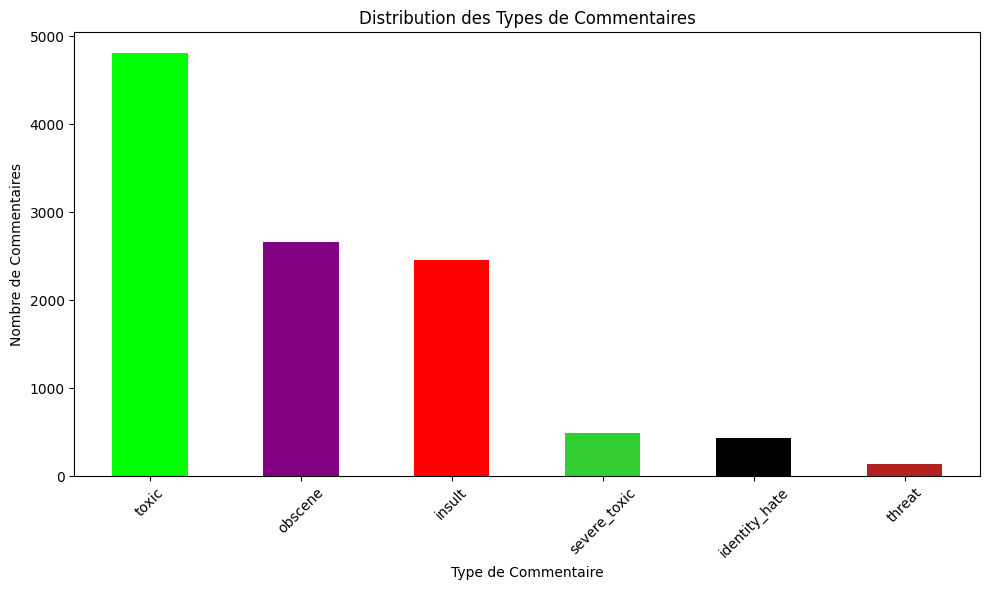

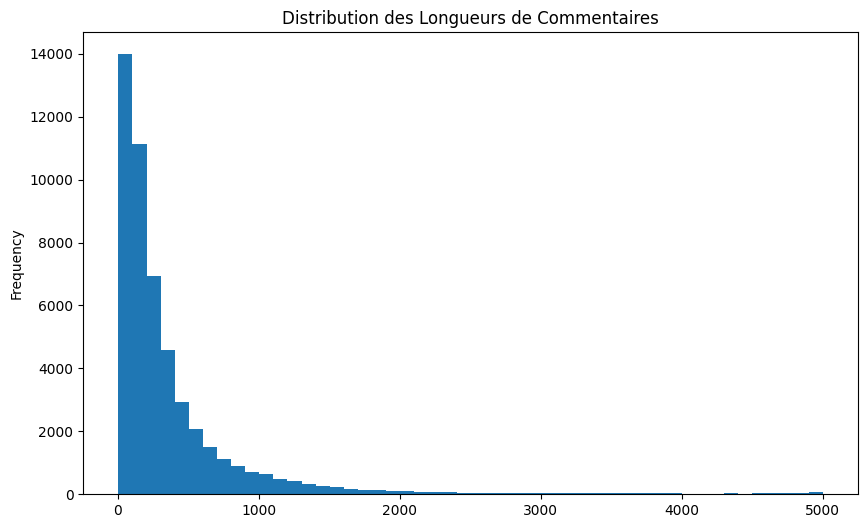

In [18]:
# Affichage des informations de base sur le dataset
print("Informations de base sur le dataset :")
print(data.info())

# Vérification des valeurs manquantes
print("\nVérification des valeurs manquantes :")
print(data.isnull().sum())

# Supprimer les lignes où le commentaire est devenu vide après nettoyage
data = data[data['cleaned_comment_text'].str.strip() != '']
print(f"\nDonnées après suppression des commentaires vides : {data.shape}\n")


# Distribution des types de commentaires
target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Liste des couleurs pour chaque type de commentaire
colors = ['#00FF00', '#800080', '#FF0000', '#32CD32', '#000000', '#B22222']

# Création d'un graphique pour la distribution des types de commentaires avec des couleurs différentes
plt.figure(figsize=(10, 6))
data[target_columns].sum().sort_values(ascending=False).plot(kind='bar', color=colors)
plt.title('Distribution des Types de Commentaires')
plt.xlabel('Type de Commentaire')
plt.ylabel('Nombre de Commentaires')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Affichage de la distribution des longueurs de commentaires
data['comment_length'] = data['comment_text'].apply(len)
data['comment_length'].plot(kind='hist', bins=50, figsize=(10, 6), title='Distribution des Longueurs de Commentaires')
plt.show()

# Entraînement du modèle baseline

##### A utilisé beaucoup trop de ram, on va tester autre choses

In [ ]:
"""# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, data[target_columns], test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_columns))

print("Confusion Matrix:")
print(confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1)))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))"""

'# Split the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(padded_sequences, data[target_columns], test_size=0.2, random_state=42)\n\n# Initialize the RandomForestClassifier\nrf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)\n\n# Train the model\nrf_classifier.fit(X_train, y_train)\n\n# Make predictions on the test set\ny_pred = rf_classifier.predict(X_test)\n\n# Evaluate the model\nprint("Classification Report:")\nprint(classification_report(y_test, y_pred, target_names=target_columns))\n\nprint("Confusion Matrix:")\nprint(confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1)))\n\nprint("Accuracy Score:")\nprint(accuracy_score(y_test, y_pred))'

In [19]:
# Fonction pour traiter chaque chunk
def process_chunk(chunk, chunk_index):
    start_time = time()
    tweet_tokenizer = TweetTokenizer()  # Définir le tweet_tokenizer

    # Nettoyage du texte
    chunk['cleaned_comment_text'] = chunk['comment_text'].apply(clean_text)

    # Supprimer les commentaires vides après nettoyage (en maintenant les indices)
    chunk = chunk[chunk['cleaned_comment_text'].str.strip() != ""].reset_index(drop=True)

    # Tokenisation
    chunk['tokenized_comment_text'] = chunk['cleaned_comment_text'].apply(tweet_tokenizer.tokenize)

    # Suppression des stopwords
    chunk['tokenized_comment_text'] = chunk['tokenized_comment_text'].apply(lambda x: [word for word in x if word not in stop_words])

    # Conversion en séquences de tokens
    sequences = tokenizer.texts_to_sequences(list(chunk['cleaned_comment_text']))  # Utilisation de `list()` pour accélérer

    # Supprimer les lignes avec NaN dans les labels et ré-aligner les indices
    chunk = chunk.dropna(subset=target_columns).reset_index(drop=True)

    # Padding
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

    # Vérification du nombre de lignes après traitement et nettoyage
    print(f"✅ Chunk {chunk_index} traité en {time() - start_time:.2f} sec - {len(chunk)} commentaires")
    print(f"✅ Taille des séquences après padding: {padded_sequences.shape[0]}")

    return padded_sequences, chunk[target_columns].values

# Paramètres de traitement en chunks
chunk_size = 10000
padded_sequences_list = []
y_list = []

# Lecture et traitement des données en chunks
for chunk_index, chunk in enumerate(pd.read_csv(file_path, chunksize=chunk_size, nrows=chunk_size * 5)):
    padded_sequences_chunk, y_chunk = process_chunk(chunk, chunk_index)
    padded_sequences_list.append(padded_sequences_chunk)
    y_list.append(y_chunk)

# Concaténation des résultats finaux
padded_sequences = np.concatenate(padded_sequences_list, axis=0)
y = np.concatenate(y_list, axis=0)

# Vérifier la taille des données
print("✅✅ Traitement terminé ! Nombre total de séquences:", padded_sequences.shape[0])
print("📊 Taille de padded_sequences:", padded_sequences.shape[0])
print("📊 Taille de y:", y.shape[0])

# Vérification de la correspondance des tailles
assert padded_sequences.shape[0] == y.shape[0], "Les tailles de X et y ne correspondent pas !"

print("🔹 Exemple final de séquences après traitement:", padded_sequences[:5])


✅ Chunk 0 traité en 8.45 sec - 9997 commentaires
✅ Taille des séquences après padding: 9997
✅ Chunk 1 traité en 8.84 sec - 9998 commentaires
✅ Taille des séquences après padding: 9998
✅ Chunk 2 traité en 5.02 sec - 10000 commentaires
✅ Taille des séquences après padding: 10000
✅ Chunk 3 traité en 6.21 sec - 10000 commentaires
✅ Taille des séquences après padding: 10000
✅ Chunk 4 traité en 9.55 sec - 9999 commentaires
✅ Taille des séquences après padding: 9999
✅✅ Traitement terminé ! Nombre total de séquences: 49994
📊 Taille de padded_sequences: 49994
📊 Taille de y: 49994
🔹 Exemple final de séquences après traitement: [[ 9830  1219    80   320    51  2083  8800    50  6933    15    61  2430
    151     7  3081    33   116  1178 11057  3134     4    46    53   238
      1   392    30     1    41    27   140    70  4008    90]
 [   54  2585    13  1357  3721    70  4693  2693    21    93    41   899
    177     0     0     0     0     0     0     0     0     0     0     0
      0     0   

# Itération de la modélisation

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 61ms/step - accuracy: 0.6695 - loss: 0.1331
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 60ms/step - accuracy: 0.9392 - loss: 0.0550
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 86s 64ms/step - accuracy: 0.9226 - loss: 0.0413
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 74s 57ms/step - accuracy: 0.8599 - loss: 0.0328
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 77s 62ms/step - accuracy: 0.6760 - loss: 0.0289
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 76s 57ms/step - accuracy: 0.6295 - loss: 0.0238
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 72s 58ms/step - accuracy: 0.5617 - loss: 0.0205
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 57ms/step - accuracy: 0.6021 - loss: 0.0171
Epoch 9/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 57ms/step - accuracy: 0.5716 - loss: 0.0151
Epoch 10/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 57ms/step - accuracy: 0.4900 - loss: 0.0152
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report with CNN:
               precision  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


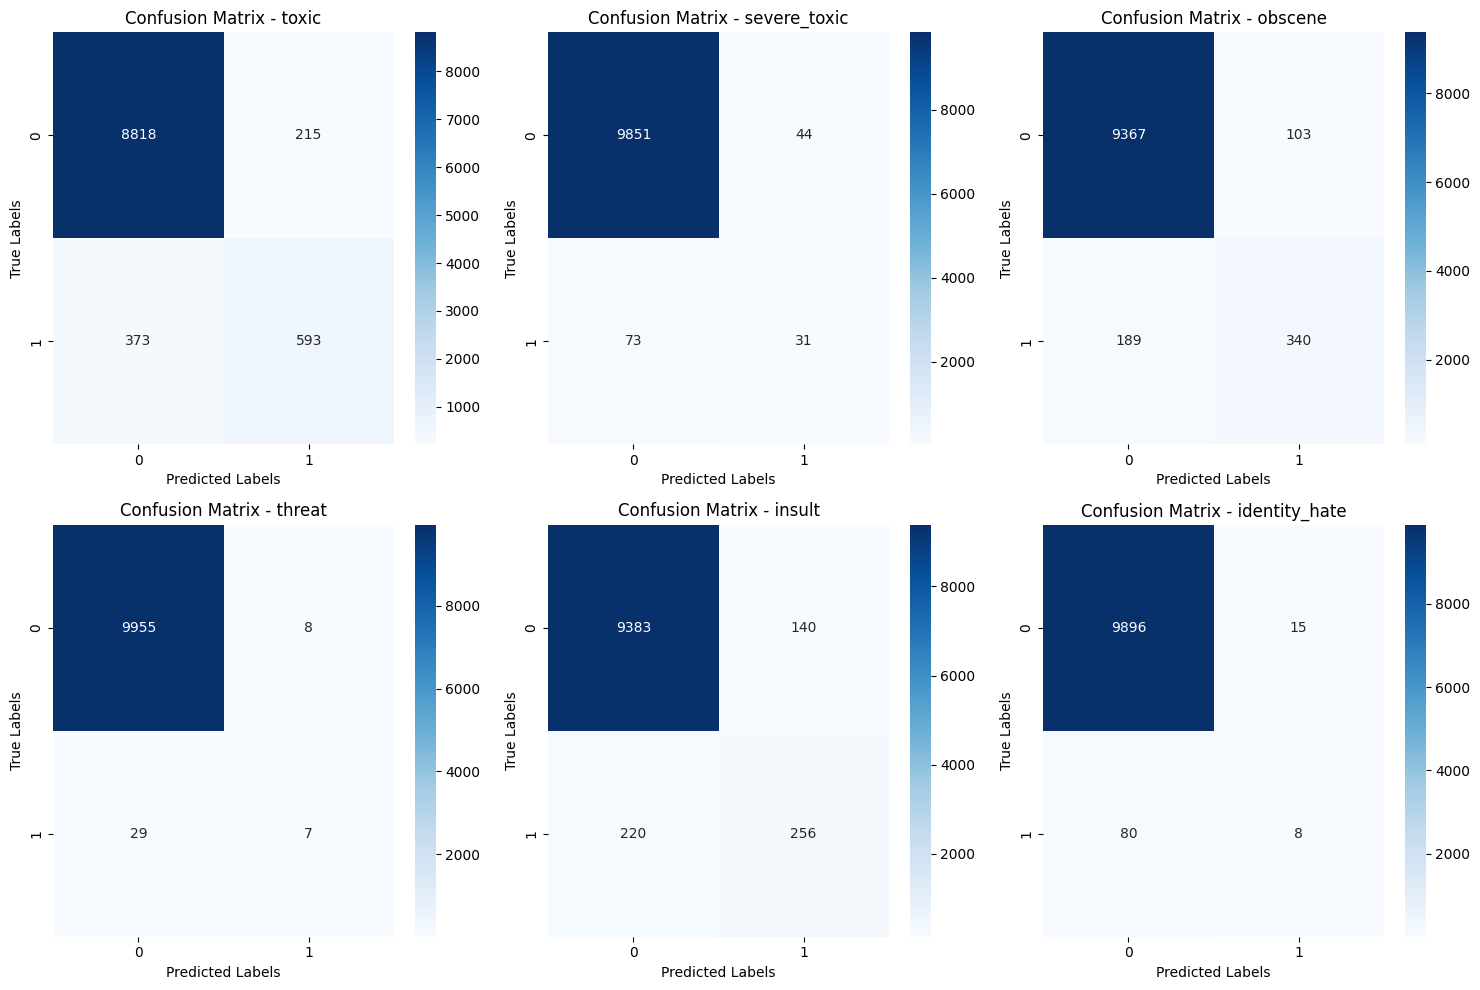

Accuracy Score with CNN:
0.896989698969897


In [16]:
# Ajuster le Tokenizer sur ton ensemble de texte
tokenizer.fit_on_texts(data['cleaned_comment_text'])

# Obtenir la taille du vocabulaire
vocab_size = len(tokenizer.word_index) + 1  # Ajouter 1 car l'index commence à 1

# Définition du modèle CNN
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(target_columns), activation='sigmoid')  # Multi-label classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Découper les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

# Entraîner le modèle
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Faire des prédictions sur l'ensemble de test
y_pred_best = model.predict(X_test)

# Convertir les prédictions en valeurs binaires en utilisant un seuil de 0.5
y_pred_best_binary = (y_pred_best > 0.5).astype(int)

# Afficher le rapport de classification
print("Classification Report with CNN:")
print(classification_report(y_test, y_pred_best_binary, target_names=target_columns))

# Calculer l'accuracy pour chaque classe
accuracies_per_class = []

for i in range(y_test.shape[1]):  # Pour chaque colonne (chaque classe)
    acc = accuracy_score(y_test[:, i], y_pred_best_binary[:, i])
    accuracies_per_class.append(acc)

# Afficher les accuracies par classe
for i, class_name in enumerate(target_columns):
    print(f"Accuracy for {class_name}: {accuracies_per_class[i]:.4f}")

# Matrice de confusion
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 6 classes = 2 lignes, 3 colonnes
#axes = axes.ravel() # Remove this line to keep axes as a 2D array

# Boucle pour chaque colonne (chaque type de commentaire)
for i, col in enumerate(target_columns):
    # Calcul de la matrice de confusion pour la colonne 'col'
    # Accéder aux données de y_test en utilisant l'indexation NumPy
    cm = confusion_matrix(y_test[:, i], y_pred_best_binary[:, i])
    # Tracer la matrice de confusion
    # Use i to index the flattened axes array
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes.flatten()[i])
    axes.flatten()[i].set_title(f'Confusion Matrix - {col}')
    axes.flatten()[i].set_xlabel('Predicted Labels')
    axes.flatten()[i].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

# Affichage du score de précision
print("Accuracy Score with CNN:")
print(accuracy_score(y_test, y_pred_best_binary))

## Entraînement avec les poids de classe

Shape of sample_weights: (39995,)
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 75s 56ms/step - accuracy: 0.8212 - loss: 1.6506
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 60s 48ms/step - accuracy: 0.9652 - loss: 1.1467
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 71s 56ms/step - accuracy: 0.9235 - loss: 0.8889
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 69s 55ms/step - accuracy: 0.9051 - loss: 0.6523
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 57ms/step - accuracy: 0.8765 - loss: 0.5602
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 68s 54ms/step - accuracy: 0.8725 - loss: 0.4928
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 71s 56ms/step - accuracy: 0.8584 - loss: 0.4291
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 64s 52ms/step - accuracy: 0.8437 - loss: 0.3971
Epoch 9/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 88s 57ms/step - accuracy: 0.8259 - loss: 0.3142
Epoch 10/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 79s 54ms/step - accuracy: 0.8170 - loss: 0.3159
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report wi

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


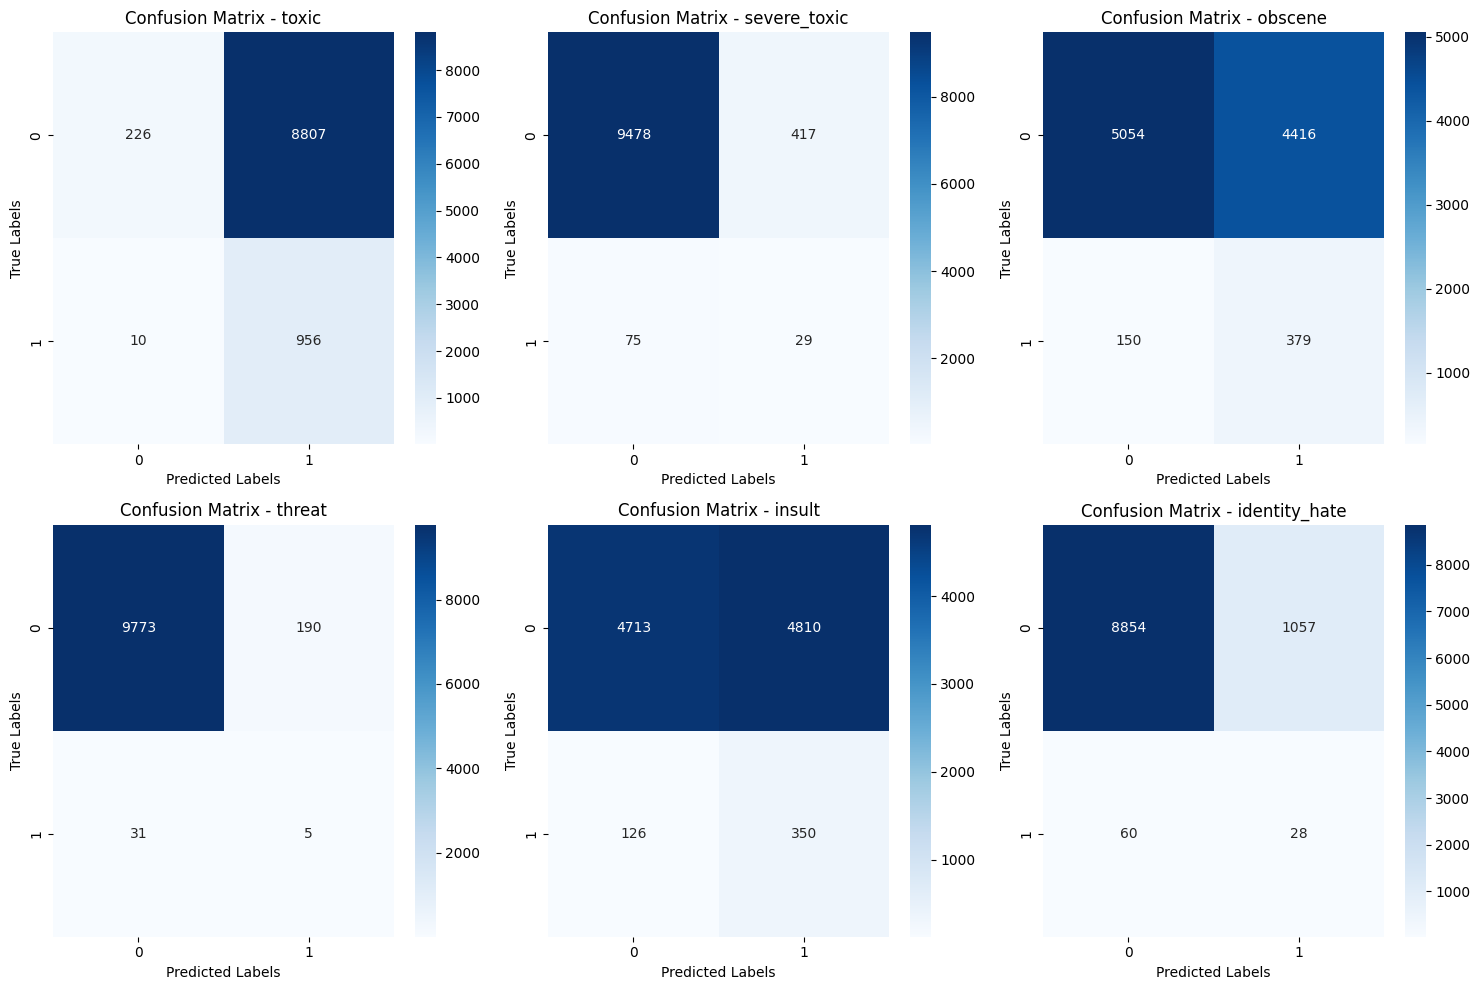

Accuracy Score with CNN:
0.0315031503150315


In [17]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calcul des poids de classe pour chaque étiquette
class_weights = []
for i in range(len(target_columns)):
    class_weights_single = compute_class_weight('balanced', classes=np.unique(y_train[:, i]), y=y_train[:, i])
    class_weight_dict_single = dict(zip(np.unique(y_train[:, i]), class_weights_single))
    class_weights.append(class_weight_dict_single)

# Appliquer un poids par étiquette sur chaque échantillon
sample_weights = np.zeros((y_train.shape[0],))  # Poids pour chaque échantillon (une valeur par échantillon)

# Pour chaque échantillon, on calcule le poids global
for i in range(len(target_columns)):
    for j in range(y_train.shape[0]):
        if y_train[j, i] == 1:  # Si l'étiquette est présente (1), on applique le poids de cette classe
            sample_weights[j] += class_weights[i].get(1, 1.0)  # Ajouter le poids de la classe présente

# Vérification que sample_weights a la forme correcte (n_samples,)
print("Shape of sample_weights:", sample_weights.shape)

# Définition du modèle CNN
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(target_columns), activation='sigmoid')  # Multi-label classification
])

# Compiler le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Découper les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

# Entraîner le modèle avec les poids de chaque échantillon
model.fit(X_train, y_train, epochs=10, batch_size=32, sample_weight=sample_weights)

# Faire des prédictions sur l'ensemble de test
y_pred_best = model.predict(X_test)

# Convertir les prédictions en valeurs binaires en utilisant un seuil de 0.5
y_pred_best_binary = (y_pred_best > 0.5).astype(int)

# Afficher le rapport de classification
print("Classification Report with CNN:")
print(classification_report(y_test, y_pred_best_binary, target_names=target_columns))

# Calculer l'accuracy pour chaque classe
accuracies_per_class = []

for i in range(y_test.shape[1]):  # Pour chaque colonne (chaque classe)
    acc = accuracy_score(y_test[:, i], y_pred_best_binary[:, i])
    accuracies_per_class.append(acc)

# Afficher les accuracies par classe
for i, class_name in enumerate(target_columns):
    print(f"Accuracy for {class_name}: {accuracies_per_class[i]:.4f}")

# Matrice de confusion
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 6 classes = 2 lignes, 3 colonnes

# Boucle pour chaque colonne (chaque type de commentaire)
for i, col in enumerate(target_columns):
    # Calcul de la matrice de confusion pour la colonne 'col'
    cm = confusion_matrix(y_test[:, i], y_pred_best_binary[:, i])
    # Tracer la matrice de confusion
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes.flatten()[i])
    axes.flatten()[i].set_title(f'Confusion Matrix - {col}')
    axes.flatten()[i].set_xlabel('Predicted Labels')
    axes.flatten()[i].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

# Affichage du score de précision
print("Accuracy Score with CNN:")
print(accuracy_score(y_test, y_pred_best_binary))


# Application des poids de classe avec Keras

Shape of sample_weights: (39995,)
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 91s 70ms/step - accuracy: 0.8161 - loss: 1.7688
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 137s 66ms/step - accuracy: 0.9181 - loss: 1.1272
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 66ms/step - accuracy: 0.9061 - loss: 0.8877
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 65ms/step - accuracy: 0.8757 - loss: 0.5952
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 65ms/step - accuracy: 0.8591 - loss: 0.5381
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 67ms/step - accuracy: 0.8622 - loss: 0.4701
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 141s 66ms/step - accuracy: 0.8719 - loss: 0.4316
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 66ms/step - accuracy: 0.8476 - loss: 0.4154
Epoch 9/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 66ms/step - accuracy: 0.8154 - loss: 0.2834
Epoch 10/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 90s 72ms/step - accuracy: 0.8243 - loss: 0.2949
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Repo

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


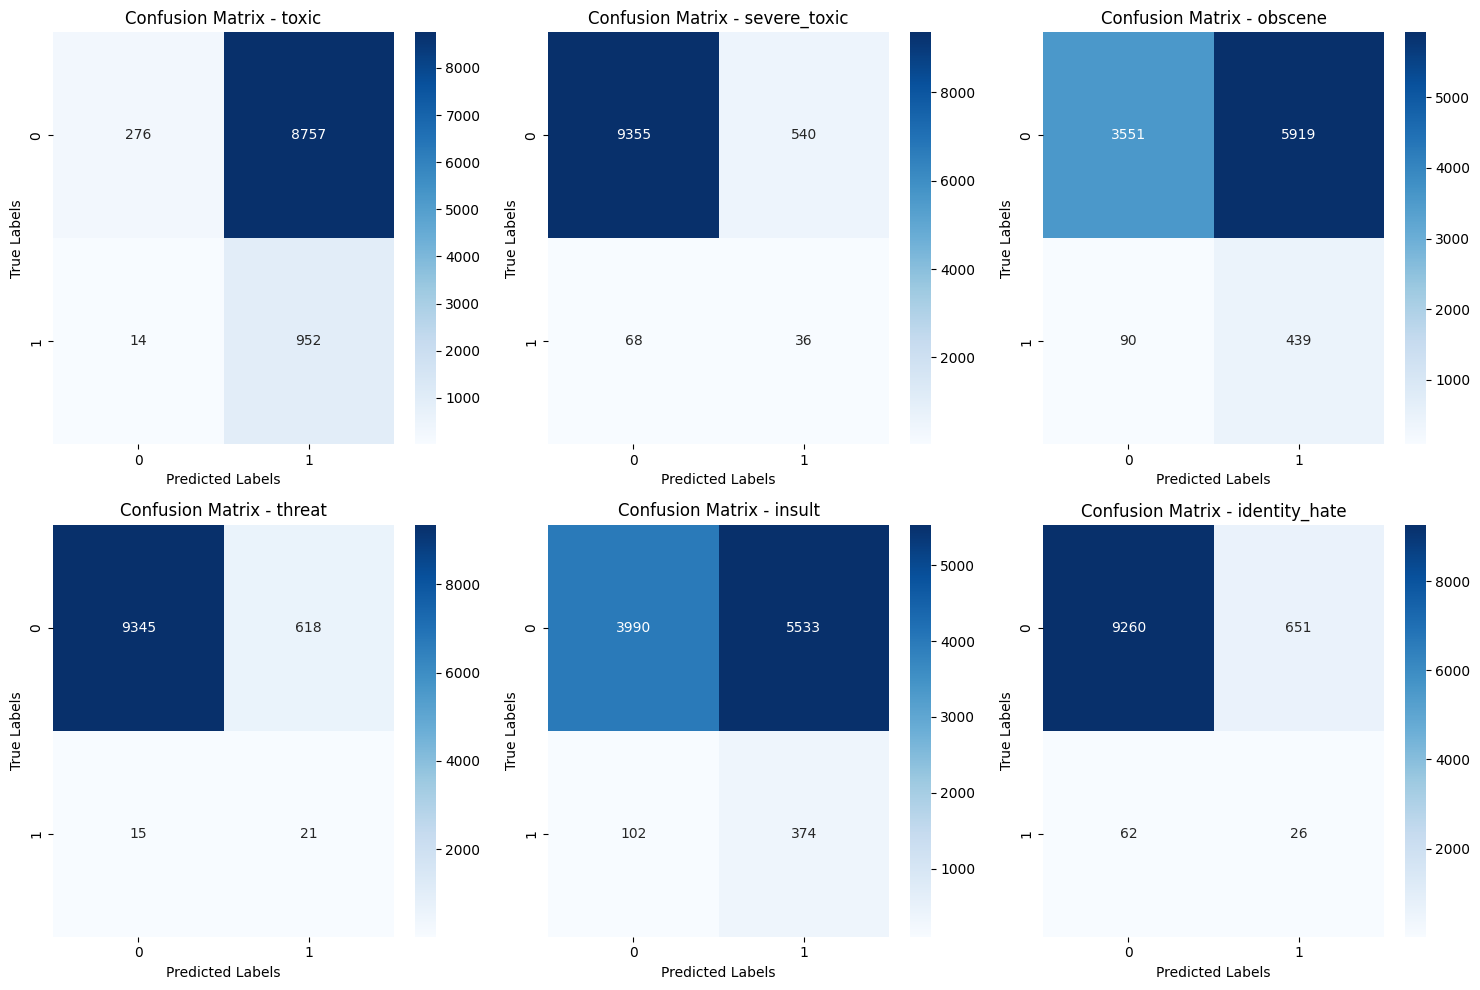

Accuracy Score with CNN:
0.032003200320032


In [14]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, BatchNormalization, MaxPooling1D, Dropout, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Calcul des poids de classe pour chaque étiquette
class_weights = []
for i in range(len(target_columns)):
    # Calcul des poids de classe équilibrés pour chaque étiquette
    class_weights_single = compute_class_weight('balanced', classes=np.unique(y_train[:, i]), y=y_train[:, i])
    class_weight_dict_single = dict(zip(np.unique(y_train[:, i]), class_weights_single))
    class_weights.append(class_weight_dict_single)

# Appliquer un poids par étiquette sur chaque échantillon
sample_weights = np.zeros((y_train.shape[0],))  # Poids pour chaque échantillon (une valeur par échantillon)

# Pour chaque échantillon, on calcule le poids global
for i in range(len(target_columns)):
    for j in range(y_train.shape[0]):
        if y_train[j, i] == 1:  # Si l'étiquette est présente (1), on applique le poids de cette classe
            sample_weights[j] += class_weights[i].get(1, 1.0)  # Ajouter le poids de la classe présente

# Vérification que sample_weights a la forme correcte (n_samples,)
print("Shape of sample_weights:", sample_weights.shape)

# Découper les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

# Définition du modèle CNN
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(target_columns), activation='sigmoid')  # Multi-label classification
])

# Compiler le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraîner le modèle avec les poids de chaque échantillon
model.fit(X_train, y_train, epochs=10, batch_size=32, sample_weight=sample_weights)

# Faire des prédictions sur l'ensemble de test
y_pred_best = model.predict(X_test)

# Convertir les prédictions en valeurs binaires en utilisant un seuil de 0.5
y_pred_best_binary = (y_pred_best > 0.5).astype(int)

# Afficher le rapport de classification
print("Classification Report with CNN:")
print(classification_report(y_test, y_pred_best_binary, target_names=target_columns))

# Matrice de confusion
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 6 classes = 2 lignes, 3 colonnes

# Boucle pour chaque colonne (chaque type de commentaire)
for i, col in enumerate(target_columns):
    # Calcul de la matrice de confusion pour la colonne 'col'
    cm = confusion_matrix(y_test[:, i], y_pred_best_binary[:, i])
    # Tracer la matrice de confusion
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes.flatten()[i])
    axes.flatten()[i].set_title(f'Confusion Matrix - {col}')
    axes.flatten()[i].set_xlabel('Predicted Labels')
    axes.flatten()[i].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

# Affichage du score de précision
print("Accuracy Score with CNN:")
print(accuracy_score(y_test, y_pred_best_binary))


Shape of sample_weights: (39995,)
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 68s 51ms/step - accuracy: 0.7996 - loss: 1.5898 - val_accuracy: 0.9867 - val_loss: 0.9064
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 51ms/step - accuracy: 0.9427 - loss: 1.1868 - val_accuracy: 0.9740 - val_loss: 0.8421
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 51ms/step - accuracy: 0.9287 - loss: 0.8473 - val_accuracy: 0.9709 - val_loss: 0.8968
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 50ms/step - accuracy: 0.9084 - loss: 0.6581 - val_accuracy: 0.8855 - val_loss: 1.1340
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 50ms/step - accuracy: 0.8421 - loss: 0.5163 - val_accuracy: 0.8868 - val_loss: 1.1453
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 50ms/step - accuracy: 0.8794 - loss: 0.4165 - val_accuracy: 0.8908 - val_loss: 1.1973
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 50ms/step - accuracy: 0.8382 - loss: 0.3943 - val_accuracy: 0.9145 - val_loss: 1.3222
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


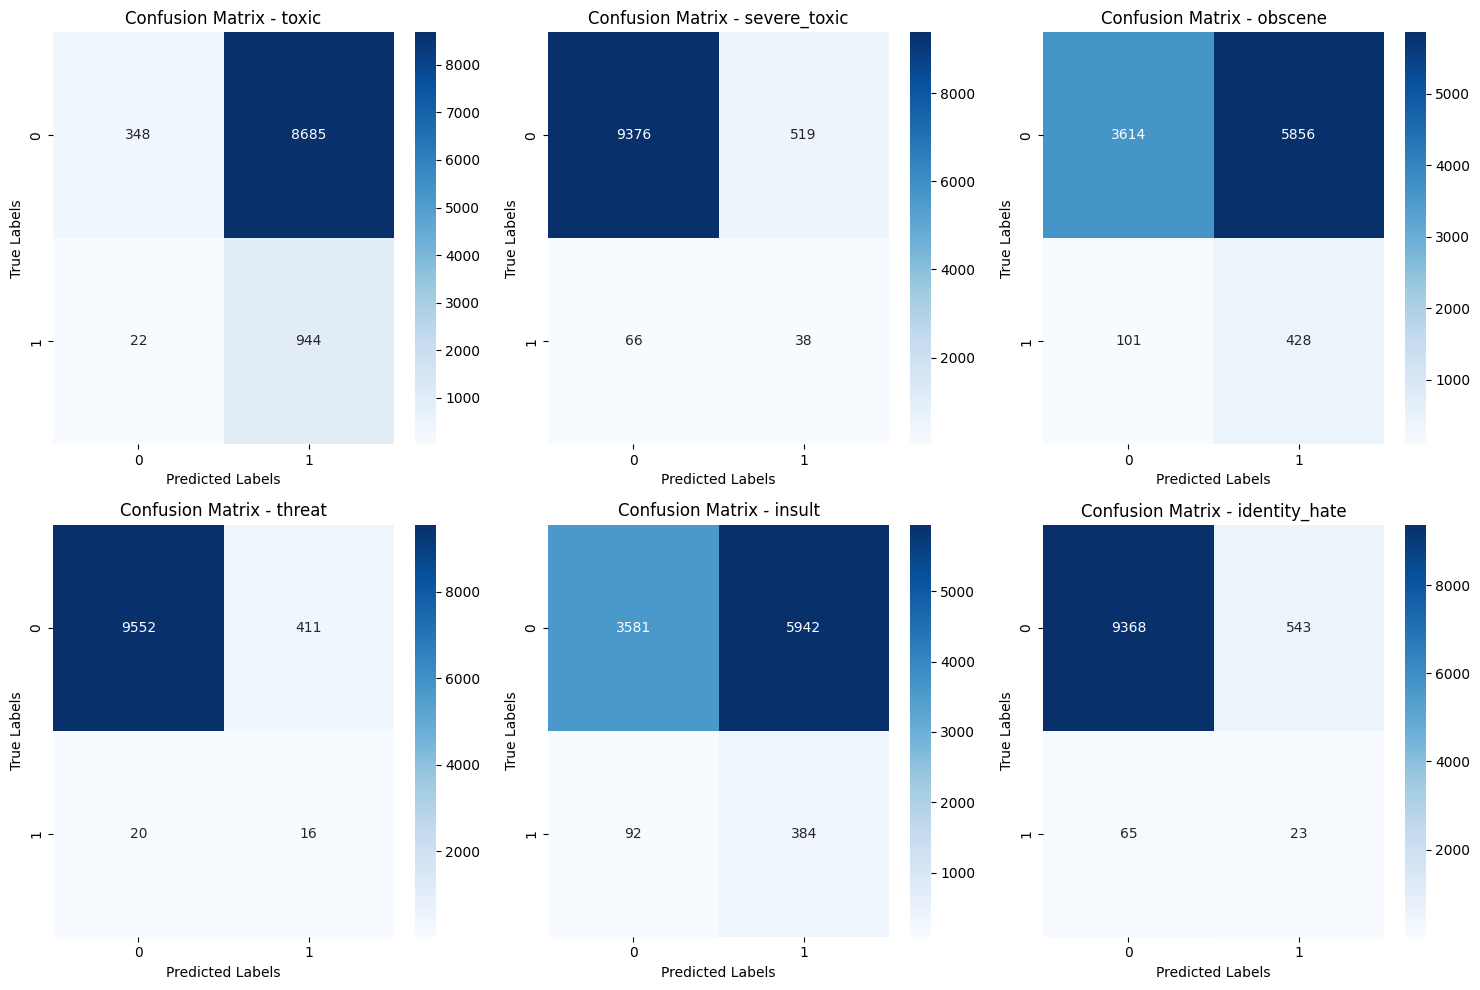

Accuracy Score with CNN:
0.028402840284028404


In [21]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, BatchNormalization, MaxPooling1D, Dropout, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Définition de la variable 'target_columns' (assure-toi que cette variable est définie avant d'exécuter le code)
target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Calcul des poids de classe pour chaque étiquette
class_weights = []
for i in range(len(target_columns)):
    # Calcul des poids de classe équilibrés pour chaque étiquette
    class_weights_single = compute_class_weight('balanced', classes=np.unique(y_train[:, i]), y=y_train[:, i])
    class_weight_dict_single = dict(zip(np.unique(y_train[:, i]), class_weights_single))
    class_weights.append(class_weight_dict_single)

# Appliquer un poids par étiquette sur chaque échantillon
sample_weights = np.zeros((y_train.shape[0],))  # Poids pour chaque échantillon (une valeur par échantillon)

# Pour chaque échantillon, on calcule le poids global
for i in range(len(target_columns)):
    for j in range(y_train.shape[0]):
        if y_train[j, i] == 1:  # Si l'étiquette est présente (1), on applique le poids de cette classe
            sample_weights[j] += class_weights[i].get(1, 1.0)  # Ajouter le poids de la classe présente

# Vérification que sample_weights a la forme correcte (n_samples,)
print("Shape of sample_weights:", sample_weights.shape)

# Découper les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

# Définition du modèle CNN
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50),  # vocab_size doit être défini avant l'exécution
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(target_columns), activation='sigmoid')  # Classification multi-label
])

# Compiler le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraîner le modèle avec les poids de chaque échantillon
model.fit(X_train, y_train, epochs=10, batch_size=32, sample_weight=sample_weights, validation_data=(X_test, y_test))

# Faire des prédictions sur l'ensemble de test
y_pred_best = model.predict(X_test)

# Convertir les prédictions en valeurs binaires en utilisant un seuil de 0.5
y_pred_best_binary = (y_pred_best > 0.5).astype(int)

# Afficher le rapport de classification
print("Classification Report with CNN:")
print(classification_report(y_test, y_pred_best_binary, target_names=target_columns))

# Matrice de confusion pour chaque classe
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 6 classes = 2 lignes, 3 colonnes
for i, col in enumerate(target_columns):
    # Calcul de la matrice de confusion pour la colonne 'col'
    cm = confusion_matrix(y_test[:, i], y_pred_best_binary[:, i])
    # Tracer la matrice de confusion
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes.flatten()[i])
    axes.flatten()[i].set_title(f'Confusion Matrix - {col}')
    axes.flatten()[i].set_xlabel('Predicted Labels')
    axes.flatten()[i].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

# Affichage du score de précision global
print("Accuracy Score with CNN:")
print(accuracy_score(y_test, y_pred_best_binary))
